In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn import ensemble
from sklearn import neural_network
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import scikitplot as skplt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
df = pd.read_csv('bankruptdata.csv')

In [3]:
df

,Bankrupt,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [4]:
shape= df.shape()
print(shape)

TypeError: 'tuple' object is not callable

In [ ]:
_, axes = plt.subplots(6,5, figsize=(15, 15))
not_bankrupt = [df.Bankrupt== 0]
is_bankrupt = [df.Bankrupt== 1]
ax = axes.ravel()                     # flatten the 2D array
for i in range(95):                   # for each of the 30 features
    bins = 20
    #---plot histogram for each feature---
    ax[i].hist(not_bankrupt[:i], bins=bins, color='r', alpha=.5)
    ax[i].hist(is_bankrupt[:i], bins=bins, color='b', alpha=0.3)
    #---set the title---
    #---display the legend---
    ax[i].legend(['not_bankrupt','is_bankrupt'], loc='best', fontsize=8)
    
plt.tight_layout()
plt.show()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt                                                  6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [6]:
df['Bankrupt'].value_counts()

0    6599
1     220
Name: Bankrupt, dtype: int64

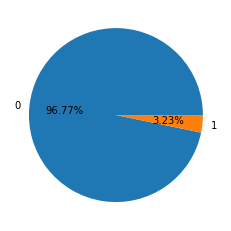

In [7]:
data = df["Bankrupt"].value_counts()
plt.pie(data,autopct='%1.2f%%',labels=data.index)
plt.show()

In [8]:
X = df.copy() 

y = df['Bankrupt']

X = X.drop(['Bankrupt'], axis=1)

# Check for collinearity

In [9]:
df_corr = df.corr()['Bankrupt'].abs().sort_values(ascending=False)
df_corr

Bankrupt                                                    1.000000
 Net Income to Total Assets                                 0.315457
 ROA(A) before interest and % after tax                     0.282941
 ROA(B) before interest and depreciation after tax          0.273051
 ROA(C) before interest and depreciation before interest    0.260807
                                                              ...   
 Long-term Liability to Current Assets                      0.000778
 Cash Flow to Sales                                         0.000479
 Realized Sales Gross Profit Growth Rate                    0.000458
 Operating Profit Rate                                      0.000230
 Net Income Flag                                                 NaN
Name: Bankrupt, Length: 96, dtype: float64

In [10]:
# get all the features that has at least 0.1 in correlation to the 
# target
features = df_corr[df_corr > 0.1].index.to_list()[1:]
len(features)                         

32

# Multicolinearity: VIF >5 means high multi collinearity

In [11]:
import pandas as pd
from sklearn.linear_model import LinearRegression 
def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})
calculate_vif(df,features)

C:\Users\DIVYA\AppData\Local\Temp\ipykernel_26532\41369364.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1/(tolerance[feature])
C:\Users\DIVYA\AppData\Local\Temp\ipykernel_26532\41369364.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1/(tolerance[feature])
C:\Users\DIVYA\AppData\Local\Temp\ipykernel_26532\41369364.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1/(tolerance[feature])
C:\Users\DIVYA\AppData\Local\Temp\ipykernel_26532\41369364.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1/(tolerance[feature])


,VIF,Tolerance
Net Income to Total Assets,2.558782e+01,3.908109e-02
ROA(A) before interest and % after tax,4.028774e+01,2.482145e-02
ROA(B) before interest and depreciation after tax,9.752349e+01,1.025394e-02
ROA(C) before interest and depreciation before interest,6.527145e+01,1.532063e-02
Net worth/Assets,inf,0.000000e+00
Debt ratio %,inf,0.000000e+00
Persistent EPS in the Last Four Seasons,3.006334e+01,3.326310e-02
Retained Earnings to Total Assets,3.579470e+00,2.793710e-01
Net profit before tax/Paid-in capital,2.907633e+01,3.439223e-02
Per Share Net profit before tax (Yuan ¥),1.983375e+01,5.041912e-02


In [12]:
df2 = calculate_vif(df, features)
df2

C:\Users\DIVYA\AppData\Local\Temp\ipykernel_26532\41369364.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1/(tolerance[feature])
C:\Users\DIVYA\AppData\Local\Temp\ipykernel_26532\41369364.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1/(tolerance[feature])
C:\Users\DIVYA\AppData\Local\Temp\ipykernel_26532\41369364.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1/(tolerance[feature])
C:\Users\DIVYA\AppData\Local\Temp\ipykernel_26532\41369364.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1/(tolerance[feature])


,VIF,Tolerance
Net Income to Total Assets,2.558782e+01,3.908109e-02
ROA(A) before interest and % after tax,4.028774e+01,2.482145e-02
ROA(B) before interest and depreciation after tax,9.752349e+01,1.025394e-02
ROA(C) before interest and depreciation before interest,6.527145e+01,1.532063e-02
Net worth/Assets,inf,0.000000e+00
Debt ratio %,inf,0.000000e+00
Persistent EPS in the Last Four Seasons,3.006334e+01,3.326310e-02
Retained Earnings to Total Assets,3.579470e+00,2.793710e-01
Net profit before tax/Paid-in capital,2.907633e+01,3.439223e-02
Per Share Net profit before tax (Yuan ¥),1.983375e+01,5.041912e-02


In [13]:
calculate_vif(df, features)['VIF'].sort_values()





C:\Users\DIVYA\AppData\Local\Temp\ipykernel_26532\41369364.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1/(tolerance[feature])
C:\Users\DIVYA\AppData\Local\Temp\ipykernel_26532\41369364.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1/(tolerance[feature])
C:\Users\DIVYA\AppData\Local\Temp\ipykernel_26532\41369364.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1/(tolerance[feature])
C:\Users\DIVYA\AppData\Local\Temp\ipykernel_26532\41369364.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1/(tolerance[feature])


 Tax rate (A)                                               1.285241e+00
 Liability-Assets Flag                                      1.471353e+00
 CFO to Assets                                              1.582552e+00
 Cash/Total Assets                                          1.811377e+00
 Current Liability to Current Assets                        1.814503e+00
 Total expense/Assets                                       2.289977e+00
 Retained Earnings to Total Assets                          3.579470e+00
 Working Capital to Total Assets                            3.770177e+00
 Working Capital/Equity                                     3.974909e+00
 Net Income to Stockholder's Equity                         5.006578e+00
 Current Liability to Assets                                5.798621e+00
 Per Share Net profit before tax (Yuan ¥)                   1.983375e+01
 Borrowing dependency                                       2.206654e+01
 Net Income to Total Assets                        

In [14]:
features_to_remove = df2.loc[df2['VIF'] < 5]
features_to_remove



,VIF,Tolerance
Retained Earnings to Total Assets,3.579470,0.279371
Working Capital to Total Assets,3.770177,0.265240
Current Liability to Current Assets,1.814503,0.551115
Working Capital/Equity,3.974909,0.251578
Liability-Assets Flag,1.471353,0.679647
Total expense/Assets,2.289977,0.436686
CFO to Assets,1.582552,0.631891
Tax rate (A),1.285241,0.778064
Cash/Total Assets,1.811377,0.552066


In [15]:
X = df.copy() 

y = df['Bankrupt']

X = X.drop(['Bankrupt'], axis=1)

In [16]:
X.columns

Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit Growth Rate'

In [17]:
X

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,0.781588,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,0.781586,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,0.781546,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,0.781663,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [18]:
import numpy as np
var = np.var(X)

In [19]:
print(var)

 ROA(C) before interest and depreciation before interest    3.682207e-03
 ROA(A) before interest and % after tax                     4.305357e-03
 ROA(B) before interest and depreciation after tax          3.793364e-03
 Operating Gross Margin                                     2.867120e-04
 Realized Sales Gross Margin                                2.861115e-04
                                                                ...     
 Liability to Equity                                        2.091542e-04
 Degree of Financial Leverage (DFL)                         2.454484e-04
 Interest Coverage Ratio (Interest expense to EBIT)         1.745905e-04
 Net Income Flag                                            1.232595e-32
 Equity to Liability                                        2.501005e-03
Length: 95, dtype: float64


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [21]:
X_train.shape, X_test.shape

((5455, 95), (1364, 95))

In [22]:
#Feature Scalling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [23]:
#1. Logestic Regression
from sklearn.linear_model import LogisticRegression
lgclassifier = LogisticRegression(random_state = 42)
lgclassifier.fit(X_train, y_train)

C:\Users\DIVYA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [24]:
y_pred = lgclassifier.predict(X_test)
print(y_pred)

[0 0 0 ... 0 0 0]


In [25]:
y_pred = lgclassifier.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1306    7]
 [  41   10]]


[[1306    7]
 [  41   10]]


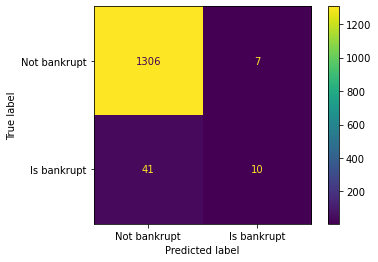

In [26]:
c_matrix = confusion_matrix(y_test,y_pred)
#print confusion matrix
print(c_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix,display_labels=["Not bankrupt", "Is bankrupt"])
disp.plot()
plt.show()

In [27]:
y_val_scores = lgclassifier.predict_proba(X_test)
print(y_val_scores)

y_train_scores = lgclassifier.predict_proba(X_train)
print(y_train_scores)

[[9.98387582e-01 1.61241833e-03]
 [9.91474936e-01 8.52506438e-03]
 [9.99811051e-01 1.88948651e-04]
 ...
 [9.54486734e-01 4.55132657e-02]
 [9.73380318e-01 2.66196823e-02]
 [9.99776416e-01 2.23584454e-04]]
[[9.87633493e-01 1.23665068e-02]
 [9.88646217e-01 1.13537827e-02]
 [9.97796624e-01 2.20337561e-03]
 ...
 [9.95038177e-01 4.96182304e-03]
 [9.99709154e-01 2.90846189e-04]
 [9.99780092e-01 2.19908176e-04]]


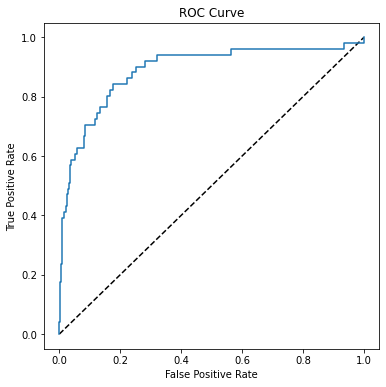

In [28]:
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_val_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,y_val_scores[:,1])
print('AUC: ' + str(auc))

AUC: 0.8889984021026537


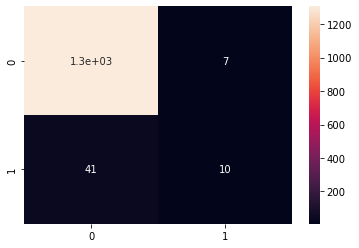

In [30]:
sns.heatmap(cm,annot=True)
plt.show()

In [31]:
from sklearn.metrics import accuracy_score
acc1 = accuracy_score(y_test, y_pred)
print("Accuracy score for Logistic Regression Model: {:.2f} %".format(acc1*100))

Accuracy score for Logistic Regression Model: 96.48 %


In [32]:
predictions_val = lgclassifier.predict(X_test)
predictions_train = lgclassifier.predict(X_train)

In [33]:
from sklearn. metrics import classification_report

print('Validation Data Classification Report \n', classification_report(y_test, predictions_val))
print('Train Data Classification Report \n', classification_report(y_train, predictions_train))

Validation Data Classification Report 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1313
           1       0.59      0.20      0.29        51

    accuracy                           0.96      1364
   macro avg       0.78      0.60      0.64      1364
weighted avg       0.96      0.96      0.96      1364

Train Data Classification Report 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      5286
           1       0.64      0.27      0.38       169

    accuracy                           0.97      5455
   macro avg       0.81      0.63      0.68      5455
weighted avg       0.97      0.97      0.97      5455



In [34]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1313
           1       0.59      0.20      0.29        51

    accuracy                           0.96      1364
   macro avg       0.78      0.60      0.64      1364
weighted avg       0.96      0.96      0.96      1364



In [35]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,y_val_scores[:,1])
print('AUC: ' + str(auc))

AUC: 0.8889984021026537


In [36]:
resultsLogisticRegression = pd.DataFrame({'Train Accuracy': accuracy_score(y_train, predictions_train),
              'Test Accuracy': accuracy_score(y_test, predictions_val),
              'Train F1 Score':f1_score(y_train, predictions_train),
              'Test F1 Score':f1_score(y_test, predictions_val),
              'Train Precision':precision_score(y_train, predictions_train),
              'Test Precision': precision_score(y_test, predictions_val),
              'Train Recall':recall_score(y_train, predictions_train),
              'Test Recall': recall_score(y_test, predictions_val),
              'ROC AUC':auc},
             index=['LogisticRegression'])
resultsLogisticRegression

,Train Accuracy,Test Accuracy,Train F1 Score,Test F1 Score,Train Precision,Test Precision,Train Recall,Test Recall,ROC AUC
LogisticRegression,0.972686,0.964809,0.376569,0.294118,0.642857,0.588235,0.266272,0.196078,0.888998


In [37]:
#K-NN
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [38]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1307    6]
 [  45    6]]


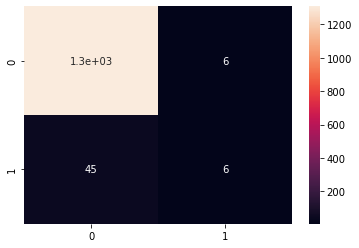

In [39]:
sns.heatmap(cm,annot=True)
plt.show()

In [40]:
acc3 = accuracy_score(y_test, y_pred)
print("Best Accuracy of K-NN: {:.2f} %".format(acc3*100))

Best Accuracy of K-NN: 96.26 %


In [41]:
test_error_rates = []
for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_pred_test=knn_model.predict(X_test)
    test_error = 1-accuracy_score(y_test,y_pred_test)
    test_error_rates.append(test_error)
print(test_error_rates.index(min(test_error_rates)))

6


In [42]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1313
           1       0.50      0.12      0.19        51

    accuracy                           0.96      1364
   macro avg       0.73      0.56      0.59      1364
weighted avg       0.95      0.96      0.95      1364



Text(0.5, 0, 'K Neighbors')

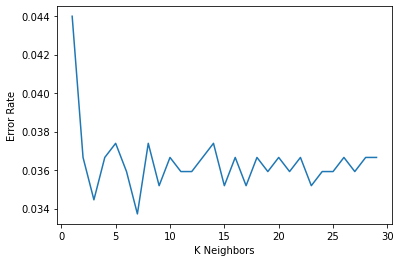

In [43]:
plt.plot(range(1,30), test_error_rates)
plt.ylabel("Error Rate")
plt.xlabel("K Neighbors")

In [44]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [45]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
acc6 = accuracy_score(y_test, y_pred)

[[1308    5]
 [  41   10]]


In [46]:
print(f"Random Forest Classification accuracy: {acc6}")

Random Forest Classification accuracy: 0.966275659824047


# PCA

In [47]:
from sklearn.decomposition import PCA
 
pca = PCA(n_components = 2)
 
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
 
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.13366614, 0.07267898])

In [48]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 42)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [49]:
y_pred = classifier.predict(X_test)
print(y_pred)

[0 0 0 ... 0 0 0]


In [50]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1309    4]
 [  45    6]]


[[1309    4]
 [  45    6]]


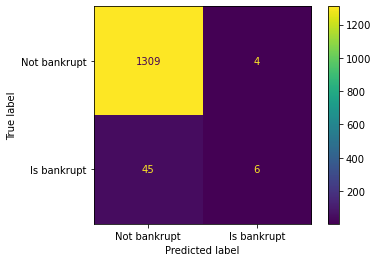

In [51]:
c_matrix = confusion_matrix(y_test,y_pred)
#print confusion matrix
print(c_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix,display_labels=["Not bankrupt", "Is bankrupt"])
disp.plot()
plt.show()

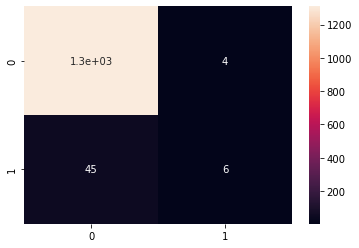

In [52]:
sns.heatmap(cm,annot=True)
plt.show()

In [53]:
from sklearn.metrics import accuracy_score
acc1 = accuracy_score(y_test, y_pred)
print("Accuracy score for Logistic Regression Model: {:.2f} %".format(acc1*100))

Accuracy score for Logistic Regression Model: 96.41 %


In [54]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score

In [55]:
predictions_val = classifier.predict(X_test)
predictions_train = classifier.predict(X_train)

In [56]:
from sklearn. metrics import classification_report
print('Validation Data Classification Report \n', classification_report(y_test, predictions_val))

Validation Data Classification Report 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1313
           1       0.60      0.12      0.20        51

    accuracy                           0.96      1364
   macro avg       0.78      0.56      0.59      1364
weighted avg       0.95      0.96      0.95      1364



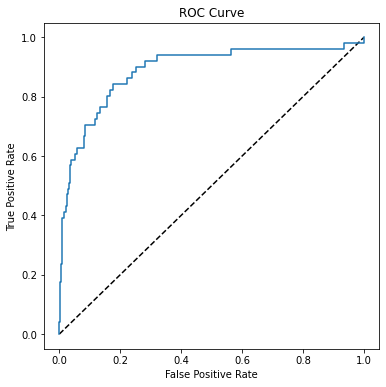

In [57]:
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_val_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [58]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,y_val_scores[:,1])
print('AUC: ' + str(auc))

AUC: 0.8889984021026537


In [59]:
resultsLogisticRegression = pd.DataFrame({'Train Accuracy': accuracy_score(y_train, predictions_train),
              'Test Accuracy': accuracy_score(y_test, predictions_val),
              'Train F1 Score':f1_score(y_train, predictions_train),
              'Test F1 Score':f1_score(y_test, predictions_val),
              'Train Precision':precision_score(y_train, predictions_train),
              'Test Precision': precision_score(y_test, predictions_val),
              'Train Recall':recall_score(y_train, predictions_train),
              'Test Recall': recall_score(y_test, predictions_val),
              'ROC AUC':auc},
             index=['LogisticRegression'])
resultsLogisticRegression

,Train Accuracy,Test Accuracy,Train F1 Score,Test F1 Score,Train Precision,Test Precision,Train Recall,Test Recall,ROC AUC
LogisticRegression,0.968653,0.964076,0.173913,0.196721,0.473684,0.6,0.106509,0.117647,0.888998


# FEATURE SELECTION

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [62]:
mi = mutual_info_classif(X_train, y_train)
mi

array([0.03188334, 0.03222833, 0.02780574, 0.01272108, 0.0113264 ,
       0.01719589, 0.02727278, 0.02704241, 0.02378808, 0.03293224,
       0.00253392, 0.        , 0.01191673, 0.00130725, 0.01336661,
       0.02935643, 0.02882593, 0.02689234, 0.04068379, 0.004999  ,
       0.00407528, 0.01805637, 0.03461159, 0.00570575, 0.00261295,
       0.01183244, 0.01186619, 0.00985917, 0.01264603, 0.02674356,
       0.0096855 , 0.00106793, 0.02207226, 0.02230637, 0.0328482 ,
       0.03049148, 0.03061278, 0.03025389, 0.00961479, 0.03456354,
       0.00070122, 0.01718446, 0.03611836, 0.00448507, 0.00571279,
       0.00178161, 0.        , 0.        , 0.00635561, 0.00084529,
       0.00425874, 0.01658658, 0.00468781, 0.02127827, 0.00585749,
       0.        , 0.01267185, 0.01448149, 0.01149065, 0.0181655 ,
       0.01349973, 0.01643155, 0.00041297, 0.00156958, 0.02012045,
       0.02350751, 0.0012861 , 0.02956495, 0.02810092, 0.00756054,
       0.00395298, 0.        , 0.01231354, 0.00741479, 0.00322

#the smaller the value of the mi, the less information we can infer from the feature about the target

Text(0, 0.5, 'Mutual Information')

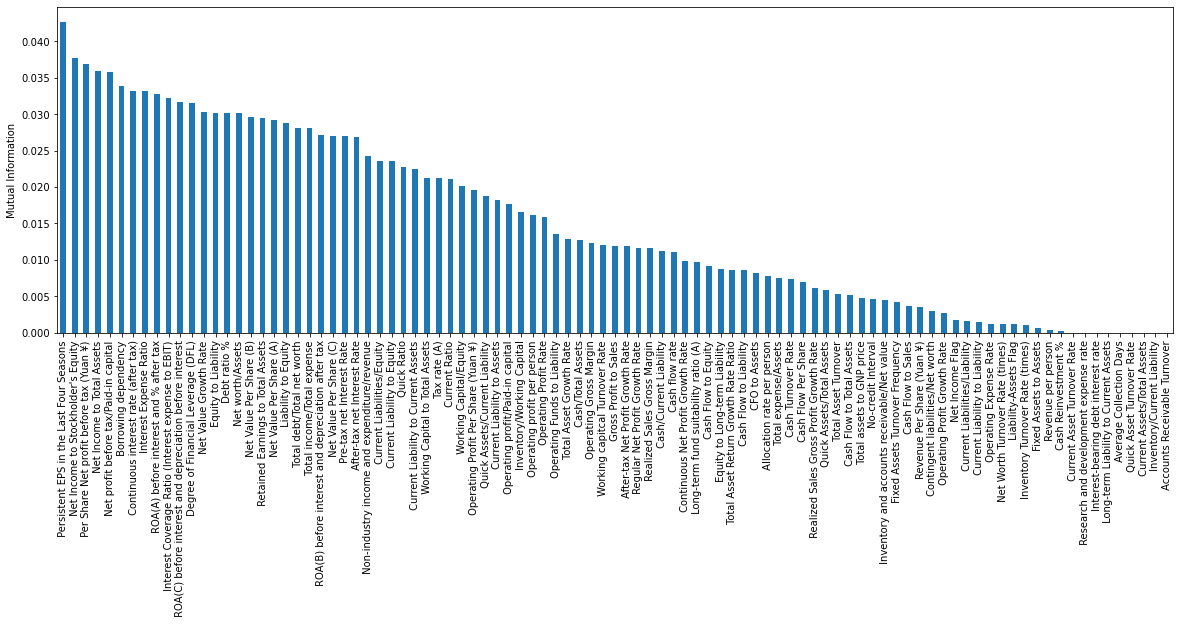

In [63]:
# the less mi value, the less information we can get from
mi = mutual_info_classif(X_train, y_train)
miseries = pd.Series(mi)
miseries
miseries.index = X_train.columns
miseries.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

#There are a few features (left of the plot) with higher mutual information values. There are also features with almost zero MI values on the right of the plot.

Once we find the mutual information values, to select features we need to determine a threshold, or cut-off value, above which a feature will be selected.

There are a few ways in which this can be done:

Select top k features, where k is an arbitrary number of features

In [64]:
# select features
sel_ = SelectKBest(mutual_info_classif, k=10).fit(X_train, y_train)

# display features
X_train.columns[sel_.get_support()]

Index([' ROA(A) before interest and % after tax',
       ' Continuous interest rate (after tax)',
       ' Persistent EPS in the Last Four Seasons',
       ' Per Share Net profit before tax (Yuan ¥)', ' Interest Expense Ratio',
       ' Borrowing dependency', ' Net profit before tax/Paid-in capital',
       ' Net Income to Total Assets', ' Net Income to Stockholder's Equity',
       ' Interest Coverage Ratio (Interest expense to EBIT)'],
      dtype='object')

In [65]:
class_count_0, class_count_1= df['Bankrupt'].value_counts()
print("class 0 count: ", class_count_0, "class 1 count:", class_count_1)
# Separate class
class_0 = df[df['Bankrupt'] == 0]
class_1 = df[df['Bankrupt'] == 1]

# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0 count:  6599 class 1 count: 220
class 0: (6599, 96)
class 1: (220, 96)


In [66]:
class_1.sample(class_count_0, replace = True).shape

(6599, 96)

In [67]:
# Oversample 1-class and concat the DataFrames of both classes
class_1_over = class_1.sample(class_count_0, replace=True)
df_test_over = pd.concat([class_0, class_1_over], axis=0)



In [68]:
print(df_test_over['Bankrupt'].value_counts())

0    6599
1    6599
Name: Bankrupt, dtype: int64


In [69]:
X_over = df_test_over.copy()
y_over = df_test_over['Bankrupt']
X_over = X_over.drop(['Bankrupt'], axis=1)

In [70]:
X = df_test_over.drop('Bankrupt',axis='columns')
y = df_test_over['Bankrupt']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)
X_train.shape, X_test.shape

((10558, 95), (2640, 95))

Text(0, 0.5, 'Mutual Information')

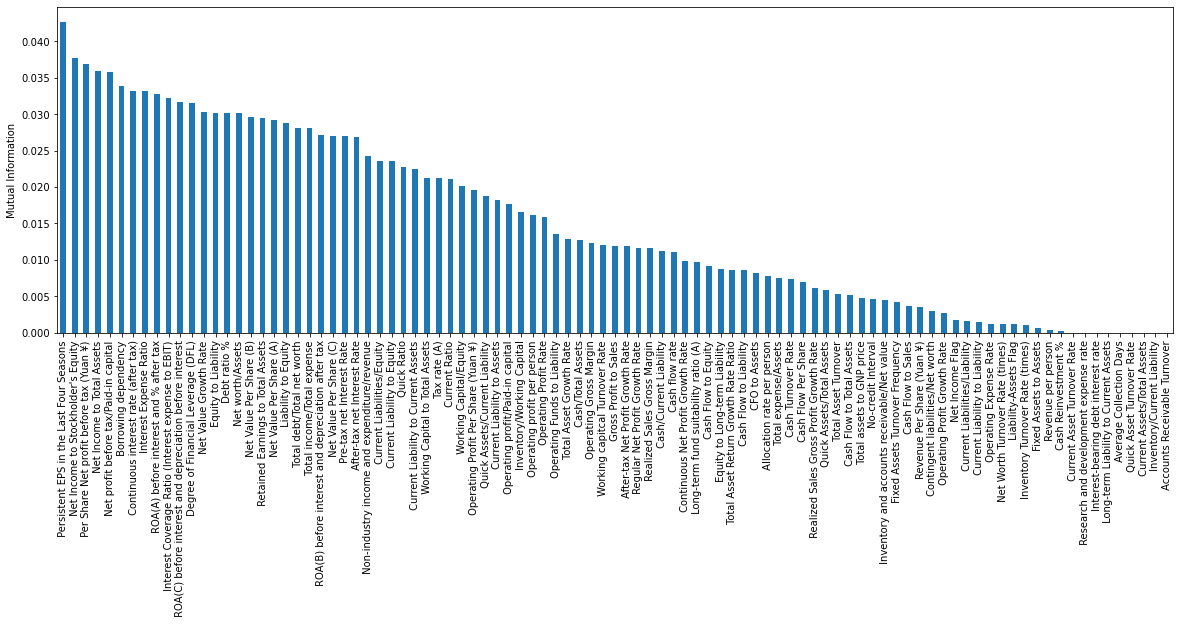

In [71]:
miseries = pd.Series(mi)
miseries
miseries.index = X_train.columns
miseries.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

In [72]:
# select features
k_best = SelectKBest(mutual_info_classif, k=10).fit(X_train, y_train)

# display features
X_train.columns[k_best.get_support()]

Index([' Net profit before tax/Paid-in capital', ' Working Capital/Equity',
       ' Current Liabilities/Equity', ' Retained Earnings to Total Assets',
       ' Total income/Total expense', ' Current Liability to Equity',
       ' Net Income to Total Assets', ' Net Income to Stockholder's Equity',
       ' Liability to Equity', ' Equity to Liability'],
      dtype='object')

In [73]:
# remove the rest of the features:
X_train = k_best.transform(X_train)
X_test = k_best.transform(X_test)
X_train.shape,X_test.shape

((10558, 10), (2640, 10))

In [74]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [75]:
lgclassifier = LogisticRegression(random_state = 42)
lgclassifier.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [76]:
y_pred = lgclassifier.predict(X_test)
print(y_pred)

[0 0 0 ... 0 0 1]


In [77]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}", "\nthe accuracy rate is lower after rebalancing using under sampling")

Accuracy: 0.8359848484848484 
the accuracy rate is lower after rebalancing using under sampling


[[1120  200]
 [ 233 1087]]


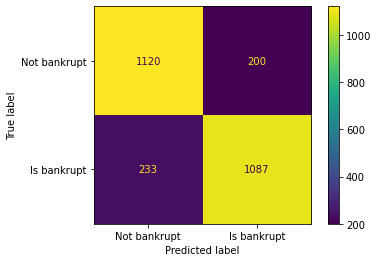

In [78]:
c_matrix = confusion_matrix(y_test,y_pred)
#print confusion matrix
print(c_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix,display_labels=["Not bankrupt", "Is bankrupt"])
disp.plot()
plt.show()

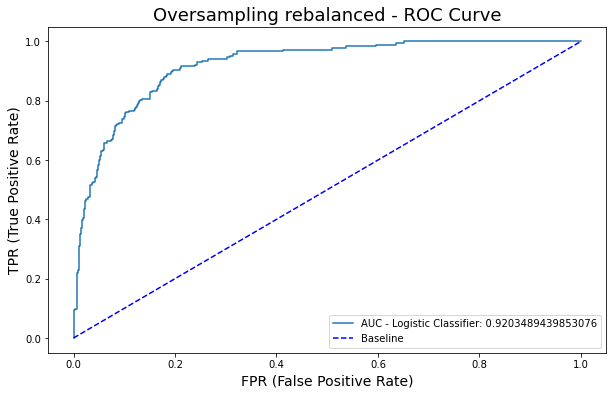

In [79]:
#plots the ROC curves
plt.figure(figsize=(10, 6))
lg_probabilities = lgclassifier.predict_proba(X_test)[:, 1]

lg_auc = roc_auc_score(y_test, lg_probabilities)
lg_fpr, lg_tpr, lg_thresholds = roc_curve(y_test, lg_probabilities)
plt.plot(lg_fpr, lg_tpr, label=f"AUC - Logistic Classifier: {lg_auc}")

plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')

plt.xlabel('FPR (False Positive Rate)', size=14)
plt.ylabel('TPR (True Positive Rate)', size=14)
plt.title('Oversampling rebalanced - ROC Curve', size=18)
plt.legend()

In [80]:
y_val_scores = lgclassifier.predict_proba(X_test)
print(y_val_scores)

y_train_scores = lgclassifier.predict_proba(X_train)
print(y_train_scores)

[[0.65142324 0.34857676]
 [0.53095134 0.46904866]
 [0.98143    0.01857   ]
 ...
 [0.9800698  0.0199302 ]
 [0.84495954 0.15504046]
 [0.32789739 0.67210261]]
[[0.06876601 0.93123399]
 [0.9386818  0.0613182 ]
 [0.52794086 0.47205914]
 ...
 [0.86636442 0.13363558]
 [0.70221741 0.29778259]
 [0.39509862 0.60490138]]


In [81]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,y_val_scores[:,1])
print('AUC: ' + str(auc))

AUC: 0.9203489439853076


In [82]:
predictions_val = lgclassifier.predict(X_test)

In [83]:
from sklearn. metrics import classification_report

print('Validation Data Classification Report \n', classification_report(y_test, predictions_val))

Validation Data Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      1320
           1       0.84      0.82      0.83      1320

    accuracy                           0.84      2640
   macro avg       0.84      0.84      0.84      2640
weighted avg       0.84      0.84      0.84      2640



In [84]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [85]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1232   88]
 [   0 1320]]


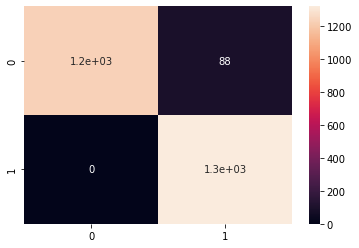

Best Accuracy of K-NN: 96.67 %


In [86]:
sns.heatmap(cm,annot=True)
plt.show()
acc3 = accuracy_score(y_test, y_pred)
print("Best Accuracy of K-NN: {:.2f} %".format(acc3*100))

In [87]:
test_error_rates = []
for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_pred_test=knn_model.predict(X_test)
    test_error = 1-accuracy_score(y_test,y_pred_test)
    test_error_rates.append(test_error)
print(test_error_rates.index(min(test_error_rates)))

0


In [88]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97      1320
           1       0.94      1.00      0.97      1320

    accuracy                           0.97      2640
   macro avg       0.97      0.97      0.97      2640
weighted avg       0.97      0.97      0.97      2640



Text(0.5, 0, 'K Neighbors')

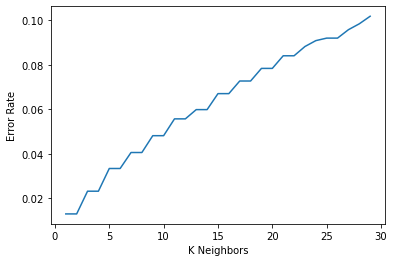

In [89]:
plt.plot(range(1,30), test_error_rates)
plt.ylabel("Error Rate")
plt.xlabel("K Neighbors")

In [90]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [91]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
acc6 = accuracy_score(y_test, y_pred)

[[1304   16]
 [   0 1320]]


In [92]:
print(f"Random Forest Classification accuracy: {acc6}")

Random Forest Classification accuracy: 0.9939393939393939


[[1304   16]
 [   0 1320]]


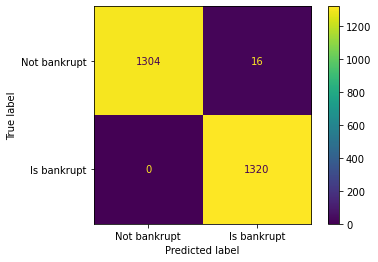

In [93]:
c_matrix = confusion_matrix(y_test,y_pred)
#print confusion matrix
print(c_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix,display_labels=["Not bankrupt", "Is bankrupt"])
disp.plot()
plt.show()

In [94]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1320
           1       0.99      1.00      0.99      1320

    accuracy                           0.99      2640
   macro avg       0.99      0.99      0.99      2640
weighted avg       0.99      0.99      0.99      2640



 # Oversampling blindly copies the current samples to create new samples
 

# SMOTE:- Creates new samples from current samples usinng K nearest neighbours algorithm

In [95]:
X = df.drop('Bankrupt',axis='columns')
y = df['Bankrupt']

In [96]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
oversample = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

1    6599
0    6599
Name: Bankrupt, dtype: int64

# TRAIN and SPLIT

In [97]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

In [98]:
# Number of classes in training Data
y_train.value_counts()

1    5279
0    5279
Name: Bankrupt, dtype: int64

# Feature selection

Text(0, 0.5, 'Mutual Information')

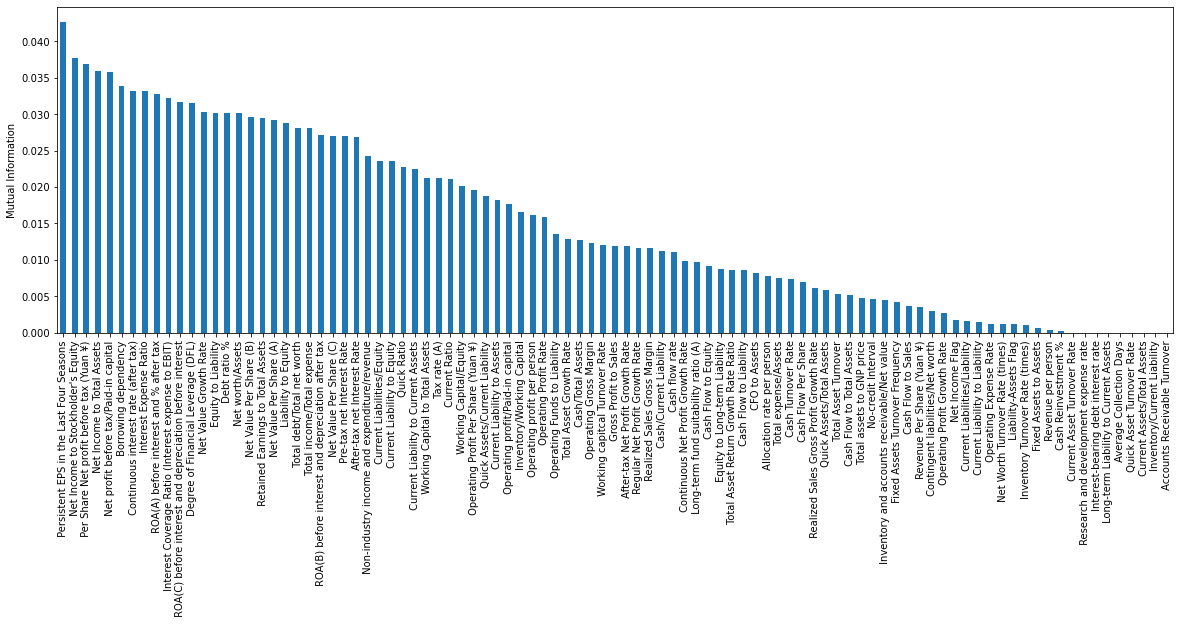

In [99]:
miseries = pd.Series(mi)
miseries
miseries.index = X_train.columns
miseries.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

In [100]:
# select features
k_best = SelectKBest(mutual_info_classif, k=10).fit(X_train, y_train)

# display features
X_train.columns[k_best.get_support()]

Index([' Continuous interest rate (after tax)',
       ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)', ' Total Asset Growth Rate',
       ' Total Asset Turnover', ' Net Worth Turnover Rate (times)',
       ' Net Income to Total Assets', ' Net Income to Stockholder's Equity'],
      dtype='object')

In [101]:
# remove the rest of the features:
X_train = k_best.transform(X_train)
X_test = k_best.transform(X_test)
X_train.shape,X_test.shape

((10558, 10), (2640, 10))

# Feature Scaling

In [102]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [103]:
lgclassifier = LogisticRegression(random_state = 42)
lgclassifier.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [104]:
y_pred = lgclassifier.predict(X_test)
print(y_pred)

[1 1 0 ... 0 0 1]


In [105]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}", "\nthe accuracy rate is increased after rebalancing using under sampling")

Accuracy: 0.8746212121212121 
the accuracy rate is increased after rebalancing using under sampling


[[1152  168]
 [ 163 1157]]


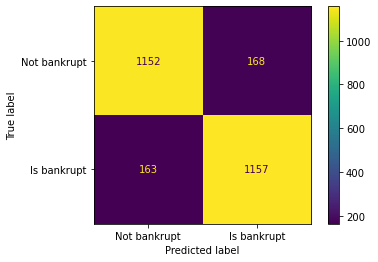

In [106]:
c_matrix = confusion_matrix(y_test,y_pred)
#print confusion matrix
print(c_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix,display_labels=["Not bankrupt", "Is bankrupt"])
disp.plot()
plt.show()

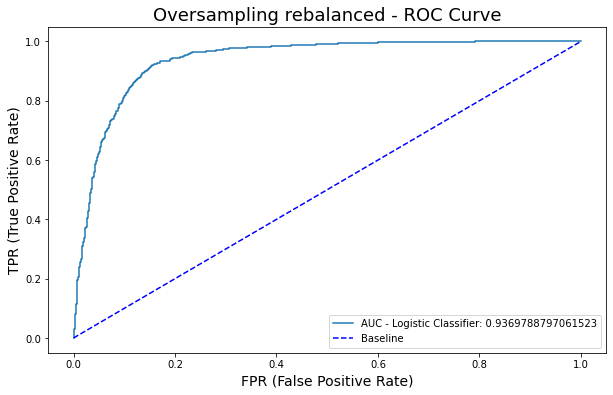

In [107]:
#plots the ROC curves
plt.figure(figsize=(10, 6))
lg_probabilities = lgclassifier.predict_proba(X_test)[:, 1]

lg_auc = roc_auc_score(y_test, lg_probabilities)
lg_fpr, lg_tpr, lg_thresholds = roc_curve(y_test, lg_probabilities)
plt.plot(lg_fpr, lg_tpr, label=f"AUC - Logistic Classifier: {lg_auc}")

plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')

plt.xlabel('FPR (False Positive Rate)', size=14)
plt.ylabel('TPR (True Positive Rate)', size=14)
plt.title('Oversampling rebalanced - ROC Curve', size=18)
plt.legend()

In [108]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,y_val_scores[:,1])
print('AUC: ' + str(auc))

AUC: 0.9203489439853076


In [109]:
predictions_val = lgclassifier.predict(X_test)

In [110]:
from sklearn. metrics import classification_report

print('Validation Data Classification Report \n', classification_report(y_test, predictions_val))

Validation Data Classification Report 
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      1320
           1       0.87      0.88      0.87      1320

    accuracy                           0.87      2640
   macro avg       0.87      0.87      0.87      2640
weighted avg       0.87      0.87      0.87      2640



# KNN

In [111]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [112]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1145  175]
 [  17 1303]]


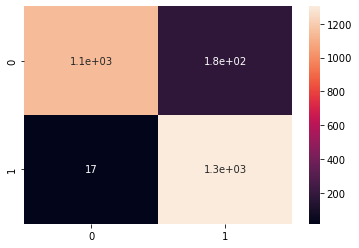

Best Accuracy of K-NN: 92.73 %


In [113]:
sns.heatmap(cm,annot=True)
plt.show()
acc3 = accuracy_score(y_test, y_pred)
print("Best Accuracy of K-NN: {:.2f} %".format(acc3*100))

In [114]:
test_error_rates = []
for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_pred_test=knn_model.predict(X_test)
    test_error = 1-accuracy_score(y_test,y_pred_test)
    test_error_rates.append(test_error)
print(test_error_rates.index(min(test_error_rates)))

0


In [115]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.87      0.92      1320
           1       0.88      0.99      0.93      1320

    accuracy                           0.93      2640
   macro avg       0.93      0.93      0.93      2640
weighted avg       0.93      0.93      0.93      2640



Text(0.5, 0, 'K Neighbors')

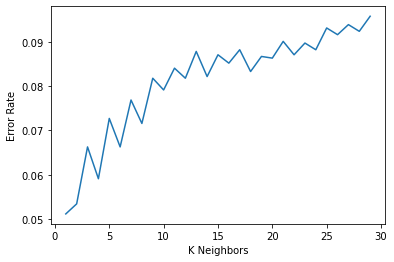

In [116]:
plt.plot(range(1,30), test_error_rates)
plt.ylabel("Error Rate")
plt.xlabel("K Neighbors")

# Random Forest Classifier

In [117]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [118]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
acc6 = accuracy_score(y_test, y_pred)


[[1235   85]
 [  47 1273]]


In [119]:
print(f"Random Forest Classification accuracy: {acc6}")

Random Forest Classification accuracy: 0.95


[[1235   85]
 [  47 1273]]


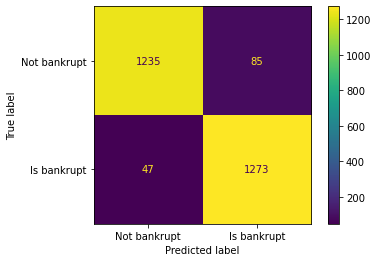

In [120]:
c_matrix = confusion_matrix(y_test,y_pred)
#print confusion matrix
print(c_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix,display_labels=["Not bankrupt", "Is bankrupt"])
disp.plot()
plt.show()


In [121]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1320
           1       0.94      0.96      0.95      1320

    accuracy                           0.95      2640
   macro avg       0.95      0.95      0.95      2640
weighted avg       0.95      0.95      0.95      2640



In [124]:
from sklearn import datasets
digits = datasets.load_digits()
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier


In [139]:
model_params = {
    'knn': {
        'model': KNeighborsClassifier(),
        'params' : {
            'n_neighbors': [1,3,5,7],
            'p': [1,2,5]
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,7,10,44,50,60]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,9,10],
            
        }
    }     
}

In [140]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(digits.data, digits.target)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,knn,0.966622,"{'n_neighbors': 3, 'p': 2}"
1,random_forest,0.942143,{'n_estimators': 60}
2,logistic_regression,0.922114,{'C': 1}


In [133]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

[[1162  158]
 [  17 1303]]


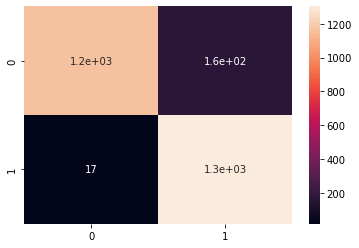

Best Accuracy of K-NN: 93.37 %


In [134]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm,annot=True)
plt.show()
acc3 = accuracy_score(y_test, y_pred)
print("Best Accuracy of K-NN: {:.2f} %".format(acc3*100))

In [135]:
test_error_rates = []
for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_pred_test=knn_model.predict(X_test)
    test_error = 1-accuracy_score(y_test,y_pred_test)
    test_error_rates.append(test_error)
print(test_error_rates.index(min(test_error_rates)))


0


In [136]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1320
           1       0.89      0.99      0.94      1320

    accuracy                           0.93      2640
   macro avg       0.94      0.93      0.93      2640
weighted avg       0.94      0.93      0.93      2640

